# **Generalized IRF**

Here I am going to plot a generalized impulse response function for an aiyagari model where the interest rate gets shocked. 
<br/>
<br/>
We have the following savings problem:
\begin{align}
\max \mathbb{E} \sum_{t=0}^{\infty} \beta^t u(c_t) \\
\end{align}
subject to:
\begin{align}
a_{t+1} + c_t \leq w z_{wt} + (1+r z_{rt})a_t
\end{align}


$\{z_{wt}\}$ and $\{z_{rt}\}$ follow both finite state markov chains with given stochastic matrices $P_w$ and $P_r$ and are shocks to the wage $w$ and interest rate $r$. 

I will choose the transition matrix for $z_{wt}$ so that the state for the wage shock doesn't change and stays in the initial state since I want to focus on the interest rate.
In order to get the generalized IRF, I will simulate two series for both the assets, and consumption
<br\>
<p style='text-align:center'>$a^1, \quad a^2 \quad \text{and} \quad c^1, \quad c^2$<p\>
<br\>
and plot the log-differences $log(\frac{a^1}{a^2})$ and $log(\frac{c^1}{c^2})$.


In [1]:
# Lets start by writing a class for combining the two shocks to make the coding more convenient later

import numpy as np
from scipy.optimize import brentq
import random
import matplotlib.pyplot as plt

class Pair:
    """
    This class, takes two markov processes, combines their state spaces
    and gives computes the corresponding transition matrix.
    """    
    
    def __init__(self,
                 a_vals = [0, 1], # state values of the first mc
                 b_vals = [1, 0], # state values of the second mc
                 P_a = [[0.9, 0.1], [0.1, 0.9]],
                 P_b = [[0.8, 0.2], [0.2, 0.8]]):
        
        self.a_vals = np.asarray(a_vals)
        self.b_vals = np.asarray(b_vals)
        self.P_a = np.asarray(P_a)
        self.P_b = np.asarray(P_b)
        self.n = len(a_vals) * len(b_vals)
        
        # Build the array with combined state values
        self.s_vals = make_statespace(self.a_vals, self.b_vals)
        
        # Combine both transition matrices
        self.Q = np.kron(self.P_b, self.P_a)
    

def make_statespace(a, b):
    """
    returns state space s_vals, when two statespaces of two independend markov 
    chains a, b are combined to s:=(a_state, b_state)
    
    Parameters
    ----------
    a,b : state spaces in form of numpy arrays containing the state values of
          the two markov chains a and b.
          
    Returns
    ---------
    state space vector : Returns a two-dimentional array 
                         [[a_state1, b_state1], [a_state2, b_state1], ...etc]
    """
    
    s_vals = []

    for j in range(len(b)):
        for i in range(len(a)):
            s_vals.append([a[i], b[j]])
    return np.array(s_vals)

now we need to write the code for the tools that we need:
<br\>
* function for simulating a markov chain
* the coleman operator (contraction mapping with the euler equation)
* a function to initialize consumption
* a function for computing fixed points
* a function that gives us a series for consumption
<br/> and assets for T periods given the initial state of
<br/> the interest rate.


In [2]:
# write a function to simulate a markov chain returning the state indices
# don't use any quantecon functions (just for fun)

def simulate_mc(Π=((0.5, 0.2, 0.3), (0.1, 0.3, 0.6), (0.7, 0.2, 0.1)), 
                T=250000,
                init_ind=0):
    
    def draw_index(p_dist):
        p_dist = np.asarray(p_dist)
        P_cum = np.cumsum(p_dist) # compute the cum prob dist (in order to be able to choose the index)
        r_num = random.uniform(0,1) # generate a unif. dist. random number
        return np.nonzero(r_num<P_cum)[0][0] # take the first index which fits the condition
    
    Π=np.asarray(Π)
    X = np.empty(T, dtype=int)
    X[0]= init_ind
    for t in range(T-1):
        X[t+1] = draw_index(Π[X[t],:])
    return X
X = simulate_mc()
np.count_nonzero(X==0)/250000 # compare to stationary distribution (with quantecon package), to check wether it works or not

0.470736

In [56]:
# write a function to compute fixed points:

def fixed_point(K, c_init, err_tol=1e-3, max_iter=300):
    i, c = 0, K(c_init)
    if np.linalg.norm((c-c_init))<err_tol:
        return c
    while max_iter>i and np.linalg.norm((c-c_init))>=err_tol:
        #if np.linalg.norm((c-c_init)) < 0.1:
            #print('err: {}, i={}'.format(np.linalg.norm((c-c_init)), i))
        i=i+1
        c_init=c
        c=K(c_init)
    return np.asarray(c)

# class to store parameters

class canersProblem:

    
    def __init__(self, 
                 r=0.01,
                 w=1,
                 β=0.96, 
                 Π_w=((0.6, 0.4), (0.05, 0.95)),
                 Π_r=((0.6, 0.4), (0.4, 0.6)),
                 z_w_vals=(0.5, 1.0),
                 z_r_vals=(2, 0.5),
                 b=0, 
                 grid_max=16, 
                 grid_size=50,
                 du=lambda x: 1/x,
                 interest_rate_shock = False):

        self.du, self.w, self.r = du, w, r
        self.grid_max, self.grid_size = grid_max, grid_size
        self.Π_w, self.Π_r = Π_w, Π_r
        self.z_w_vals, self.z_r_vals = z_w_vals, z_r_vals
        self.β, self.b, self.interest_rate_shock = β, b, interest_rate_shock
        self.asset_grid = np.linspace(-b, grid_max, grid_size)
        
        if interest_rate_shock:
            self.z = Pair(a_vals = z_r_vals,
                          b_vals = z_w_vals,
                          P_a = Π_r,
                          P_b = Π_w)
            self.Π, self.z_vals = self.z.Q, self.z.s_vals
        else:
            self.Π, self.z_vals = np.array(Π_w), tuple(z_w_vals)

# operator for contraction mapping (euler equation)
    
def coleman_operator(c, cp):

    
    # === simplify names, set up arrays === #
    r, Π, β, du, b, w = cp.r, cp.Π, cp.β, cp.du, cp.b, cp.w
    interest_rate_shock = cp.interest_rate_shock
    asset_grid, z_vals = cp.asset_grid, cp.z_vals
    z_size = len(z_vals)
    
    vals = np.empty(z_size)
    
    # === linear interpolation to get consumption function === #
    def cf(a):
        """
        The call cf(a) returns an array containing the values c(a, z)
        for each z in z_vals.  For each such z, the value c(a, z)
        is constructed by univariate linear approximation over asset
        space, based on the values in the array c
        """
        for i in range(z_size):
            vals[i] = np.interp(a, asset_grid, c[:, i])
        return vals    
    
    Kc = np.empty(c.shape)
    
    for i_a, a in enumerate(asset_grid):
        for i_z, z in enumerate(z_vals):
            if interest_rate_shock:
                z_r, z_w = z[0], z[1]
                def h(t):
                    expectation = np.dot(du(cf((1+r*z_r) * a + w * z_w - t)), Π[i_z, :])
                    return du(t) - max((1+r*z_r) * β * expectation, du((1+r*z_r) * a + w * z_w + b))
                Kc[i_a, i_z] = brentq(h, 1e-8, (1+r*z_r) * a + w * z_w + b)
            else:
                def h(t):
                    expectation = np.dot(du(cf((1+r) * a + w * z - t)), Π[i_z, :])
                    return du(t) - max((1+r) * β *  expectation, du((1+r) * a + w * z + b))
                Kc[i_a, i_z] = brentq(h, 1e-8, (1+r) * a + w * z + b)
    return Kc

# function for initializing consumption

def initialize(cp):

    # === Simplify names, set up arrays === #
    r, b, w = cp.r, cp.b, cp.w
    interest_rate_shock = cp.interest_rate_shock
    asset_grid, z_vals = cp.asset_grid, cp.z_vals
    shape = len(asset_grid), len(z_vals)
    c = np.empty(shape)
    
    for i_a, a in enumerate(asset_grid):
        for i_z, z in enumerate(z_vals):
            if interest_rate_shock:
                z_r, z_w = z[0], z[1]
                c_max = (1+r*z_r) * a + w * z_w + b
            else:
                c_max = (1+r) * a + w * z + b
            c[i_a, i_z] = c_max
    return c

# function for computing assets, consumption and interestrates (in the case of interest rate shock)

def compute_asset_series(cp,
                         T=250000,
                         max_iter=150,
                         init_ind = 0):
    """
    Simulates a time series of length T for assets, given optimal savings
    behavior.  Parameter cp is an instance of canersProblem
    """
    
    Π, z_vals, r, w = cp.Π, cp.z_vals, cp.r, cp.w    
    interest_rate_shock = cp.interest_rate_shock
    c_init = initialize(cp)
    K = lambda c: coleman_operator(c, cp)
    c = fixed_point(K=K, c_init=c_init, max_iter=max_iter)
    cf = lambda a, i_z: np.interp(a, cp.asset_grid, c[:, i_z])
    cons = np.zeros(T)
    interest_rates = np.zeros(T)
    wages = np.zeros(T)
    a = np.zeros(T+1)
    a[0]=1e-5 # since we have to take the log differences later
    z_seq = simulate_mc(Π=Π, T=250000, init_ind=init_ind)
    if interest_rate_shock:
        for t in range(T):
            i_z = z_seq[t]
            a[t+1] = (1+r*z_vals[i_z][0]) * a[t] + w * z_vals[i_z][1] - cf(a[t], i_z)
            cons[t] = cf(a[t], i_z)
            interest_rates[t] = r*z_vals[i_z][0]
            wages[t] = w*z_vals[i_z][1]
        return a, cons, interest_rates, wages
    else:
        for t in range(T):
            i_z = z_seq[t]
            a[t+1] = (1+r) * a[t] + w * z_vals[i_z] - cf(a[t], i_z)
            cons[t] = cf(a[t], i_z)
        return a

In [63]:
P1 = 0.6
P2 = 1-P1
P_r = ((P1, P2), (P2, P1))
p1 = 1
p2 = 1-p1
P_w = ((p1, p2),(p2, p1))
cp = canersProblem(interest_rate_shock=True, 
                   b=0, 
                   r=0.03, 
                   z_r_vals=(1.5, 0.2),
                   Π_w = P_w,
                   Π_r = P_r)
T=200
a0, c0, r0, w0 = compute_asset_series(cp, T=T, max_iter=300, init_ind=0) # low wage
a1, c1, r1, w1 = compute_asset_series(cp, T=T, max_iter=300, init_ind=1) # low wage
a2, c2, r2, w2 = compute_asset_series(cp, T=T, max_iter=300, init_ind=2) # high wage
a3, c3, r3, w3 = compute_asset_series(cp, T=T, max_iter=300, init_ind=3) # high wage

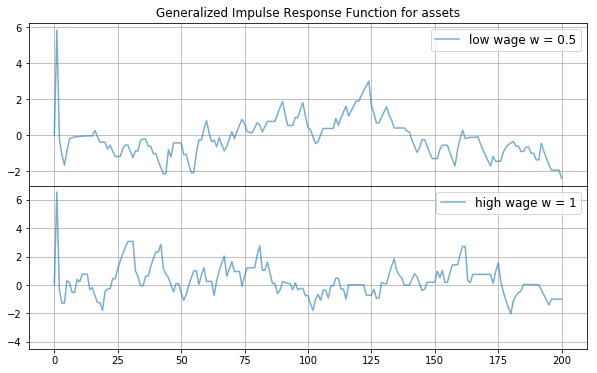

In [64]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,6))
fig.subplots_adjust(hspace=0)
ax1.plot(np.log(a0)-np.log(a1), label='low wage w = 0.5', alpha = 0.6)
ax2.plot(np.log(a2)-np.log(a3), label='high wage w = 1', alpha = 0.6)
ax1.grid(True), ax2.grid(True)
plt.ylim(-4.5,7)
ax1.legend(loc='upper right', fontsize='large'), ax2.legend(loc='upper right', fontsize='large')
ax1.set_title('Generalized Impulse Response Function for assets')

plt.show()

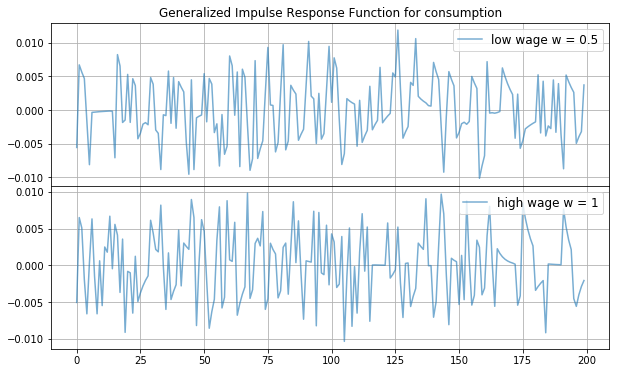

In [65]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,6))
fig.subplots_adjust(hspace=0)
ax1.plot(np.log(c0)-np.log(c1), label='low wage w = 0.5', alpha = 0.6)
ax2.plot(np.log(c2)-np.log(c3), label='high wage w = 1', alpha = 0.6)
ax1.grid(True), ax2.grid(True)
#plt.ylim(-4.5,7)
ax1.legend(loc='upper right', fontsize='large'), ax2.legend(loc='upper right', fontsize='large')
ax1.set_title('Generalized Impulse Response Function for consumption')

plt.show()

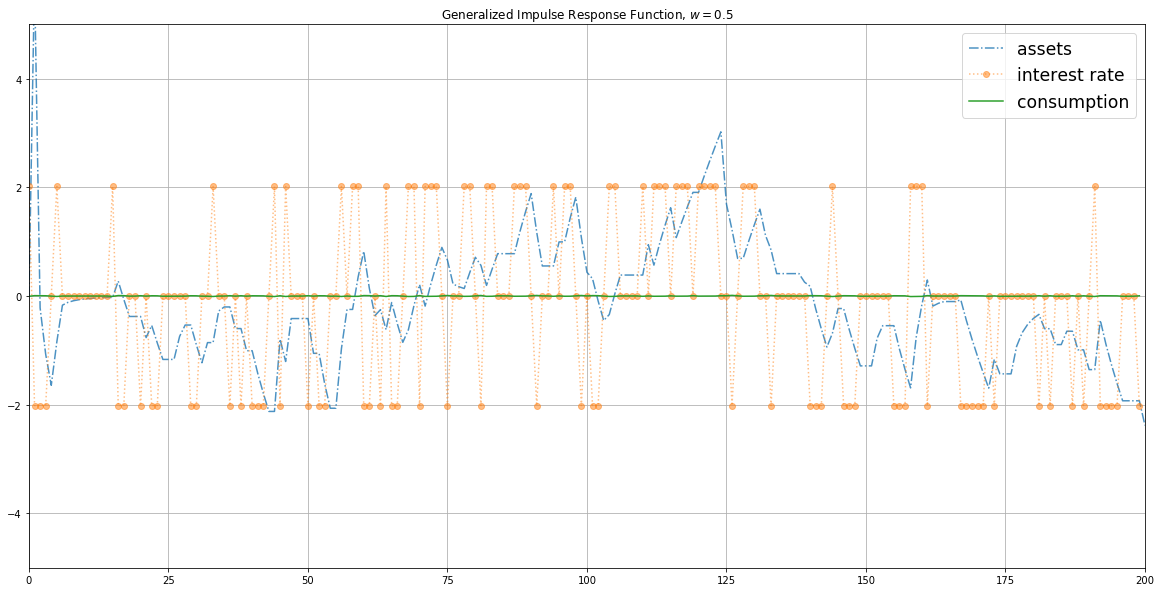

In [66]:
fig, ax1 = plt.subplots(figsize=(20,10))
fig.subplots_adjust(hspace=0.1)
ax1.plot(np.log(a0)-np.log(a1),'-.', label='assets', alpha = 0.8)
ax1.plot(np.log(r0)-np.log(r1),':o', label='interest rate', alpha = 0.5)
ax1.plot(np.log(c0)-np.log(c1), label='consumption', alpha = 1)
#ax2.plot(np.log(a2)-np.log(a3), label='assets', alpha = 0.8)
#ax2.plot(np.log(c2)-np.log(c3), label='consumption', alpha = 0.6)
ax1.grid(True), ax2.grid(True)
ax1.legend(loc='upper right', fontsize='xx-large'), #ax2.legend(loc='upper right', fontsize='xx-large')
ax1.set_title('Generalized Impulse Response Function, $w=0.5$')
#ax2.set_title('Generalized Impulse Response Function, $w=1$')
plt.ylim(-5,5)
plt.xlim(0,200)

plt.show()

Here you can see that there is not much variation in consumption (consumtpion smoothing), this makes sense since we are imposing the euler equation. the variation in the interest rate is absorbed by the savings behavior. Positive interest rate shocks lead to more assets being accumulated, and vice versa.

In [57]:
# let's see what happen if we add some volatility to the wage...

P1 = 0.6
P2 = 1-P1
P_r = ((P1, P2), (P2, P1))
p1 = 0.9
p2 = 1-p1
P_w = ((p1, p2),(p2, p1))
cp = canersProblem(interest_rate_shock=True, 
                   b=0, 
                   r=0.03, 
                   z_r_vals=(1.5, 0.2),
                   Π_w = P_w,
                   Π_r = P_r)
T=200
a0, c0, r0, w0 = compute_asset_series(cp, T=T, max_iter=300, init_ind=0) # low wage
a1, c1, r1, w1 = compute_asset_series(cp, T=T, max_iter=300, init_ind=1) # low wage
a2, c2, r2, w2 = compute_asset_series(cp, T=T, max_iter=300, init_ind=2) # high wage
a3, c3, r3, w3 = compute_asset_series(cp, T=T, max_iter=300, init_ind=3) # high wage

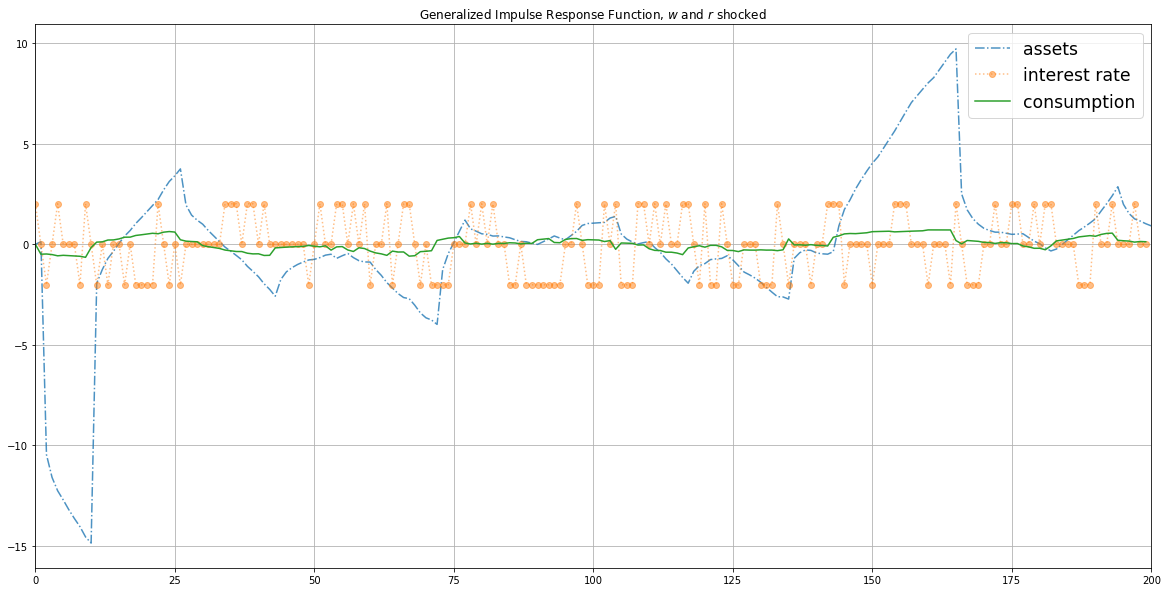

In [58]:
fig, ax1 = plt.subplots(figsize=(20,10))
fig.subplots_adjust(hspace=0.1)
ax1.plot(np.log(a0)-np.log(a1),'-.', label='assets', alpha = 0.8)
ax1.plot(np.log(r0)-np.log(r1),':o', label='interest rate', alpha = 0.5)
ax1.plot(np.log(c0)-np.log(c1), label='consumption', alpha = 1)
#ax2.plot(np.log(a2)-np.log(a3), label='assets', alpha = 0.8)
#ax2.plot(np.log(c2)-np.log(c3), label='consumption', alpha = 0.6)
ax1.grid(True), #ax2.grid(True)
ax1.legend(loc='upper right', fontsize='xx-large'), #ax2.legend(loc='upper right', fontsize='xx-large')
ax1.set_title('Generalized Impulse Response Function, $w$ and $r$ shocked')
#ax2.set_title('Generalized Impulse Response Function, $w=1$')
#plt.ylim(-2.2,2.2)
plt.xlim(0,200)

plt.show()

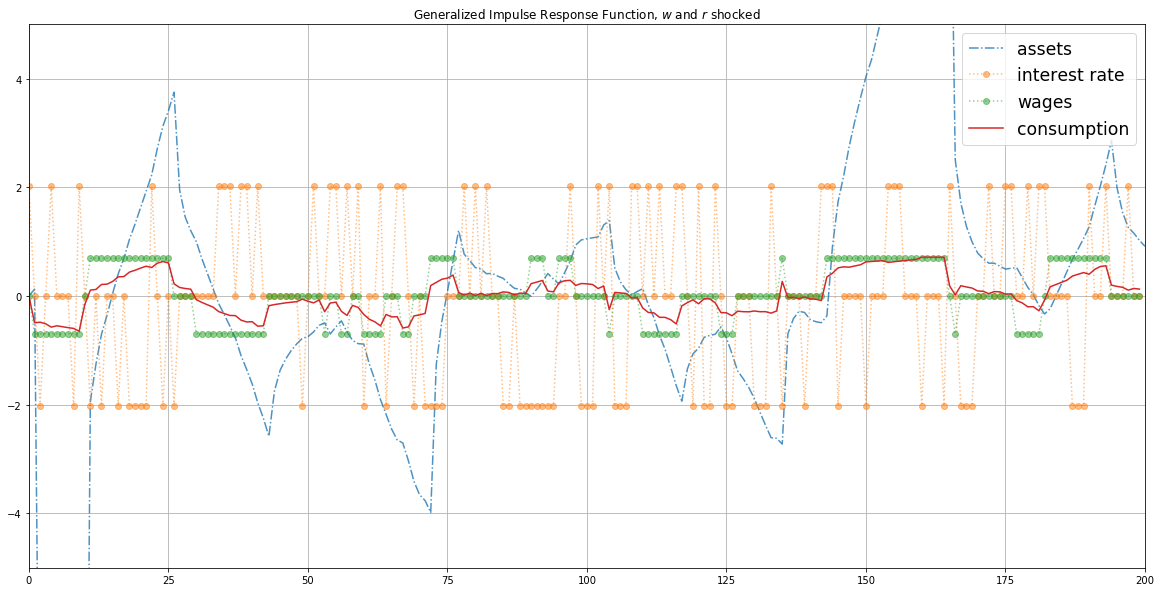

In [61]:
# let's plot the changes in wages too...

fig, ax1 = plt.subplots(figsize=(20,10))
fig.subplots_adjust(hspace=0.1)
ax1.plot(np.log(a0)-np.log(a1),'-.', label='assets', alpha = 0.8)
ax1.plot(np.log(r0)-np.log(r1),':o', label='interest rate', alpha = 0.5)
ax1.plot(np.log(w0)-np.log(w1),':o', label='wages', alpha = 0.5)
ax1.plot(np.log(c0)-np.log(c1), label='consumption', alpha = 1)
#ax2.plot(np.log(a2)-np.log(a3), label='assets', alpha = 0.8)
#ax2.plot(np.log(c2)-np.log(c3), label='consumption', alpha = 0.6)
ax1.grid(True), #ax2.grid(True)
ax1.legend(loc='upper right', fontsize='xx-large'), #ax2.legend(loc='upper right', fontsize='xx-large')
ax1.set_title('Generalized Impulse Response Function, $w$ and $r$ shocked')
#ax2.set_title('Generalized Impulse Response Function, $w=1$')
plt.ylim(-5,5)
plt.xlim(0,200)

plt.show()

Obviously, wages affect consumption more. However, most of the variation is still absorbed by the assets in this model.